In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from scipy import stats
from statistics import mode
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

PJM Interconnection LLC (PJM) is a regional transmission organization (RTO) in the United States. It is part of the Eastern Interconnection grid operating an electric transmission system serving all or parts of Delaware, Illinois, Indiana, Kentucky, Maryland, Michigan, New Jersey, North Carolina, Ohio, Pennsylvania, Tennessee, Virginia, West Virginia, and the District of Columbia.

The hourly power consumption data comes from PJM's website and are in megawatts (MW). I use PJM East Region: 2001-2018 (PJME)

The regions have changed over the years so data may only appear for certain dates per region.

I am going to use traditional models and Machine Leaning models for forecasts.

In [77]:
df = pd.read_csv('PJME_hourly.csv')
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

In [78]:
df

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0
...,...
2018-01-01 20:00:00,44284.0
2018-01-01 21:00:00,43751.0
2018-01-01 22:00:00,42402.0


In [79]:
df.describe()

,PJME_MW
count,145366.000000
mean,32080.222831
std,6464.012166
min,14544.000000
25%,27573.000000
50%,31421.000000
75%,35650.000000
max,62009.000000


Elimino Duplicados

In [80]:
print(df.index.value_counts())

2017-11-05 02:00:00    2
2015-11-01 02:00:00    2
2014-11-02 02:00:00    2
2016-11-06 02:00:00    2
2002-12-31 01:00:00    1
                      ..
2007-06-21 03:00:00    1
2007-06-21 02:00:00    1
2007-06-21 01:00:00    1
2007-06-23 00:00:00    1
2018-01-02 00:00:00    1
Name: Datetime, Length: 145362, dtype: int64


In [81]:
mask = ~df.index.duplicated()
mask


array([ True,  True,  True, ...,  True,  True,  True])

In [82]:
df = df[mask]

We we have the consumption of energy in MegaWats for day and hour between 2002/12/31 at 1:00:00 and 2018/02/02 00:00:00.

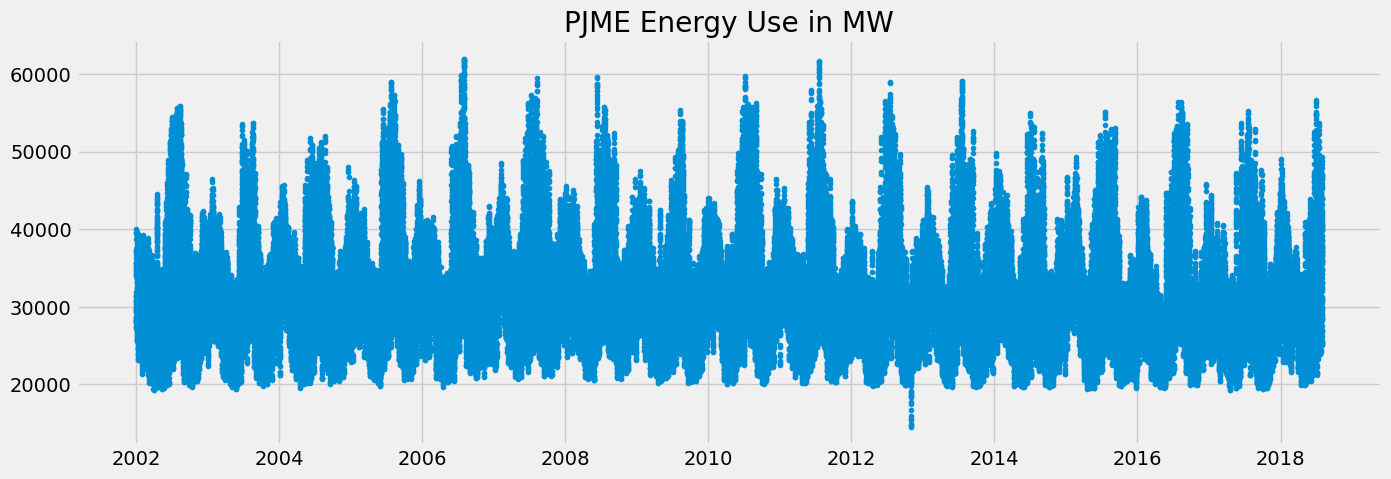

In [83]:
fig = plt.figure(figsize=(15, 5))
plt.plot(df, ".")
plt.title('PJME Energy Use in MW')
plt.show()

Look our data only in a week.

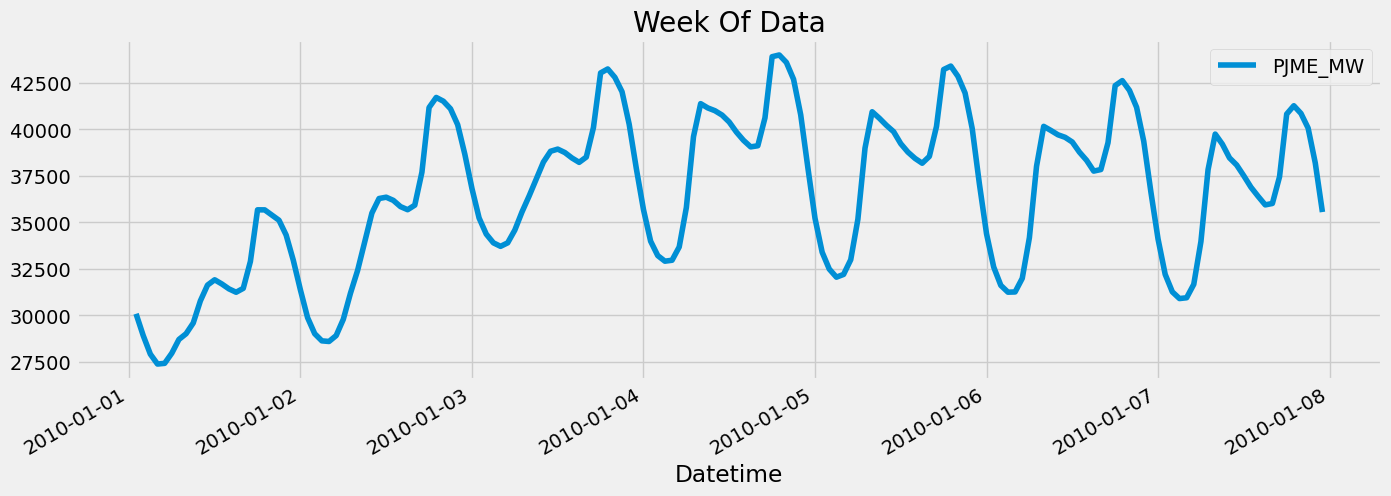

In [84]:
df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')].plot(figsize=(15, 5), title='Week Of Data')
plt.show()

Here we have two different pics (common in energy consumption) and a stronger depression in the night. We can see how in New Year we have a decrease in the consumption.

Okey, we can find some anomaly values between 2012 and 2013. Although it may be a relevant event for this region of the US, these values will influence the learning process of the model and will not contribute anything significant to its predictions beyond noise.
I going to a make a little search of outliers.

<AxesSubplot:ylabel='Frequency'>

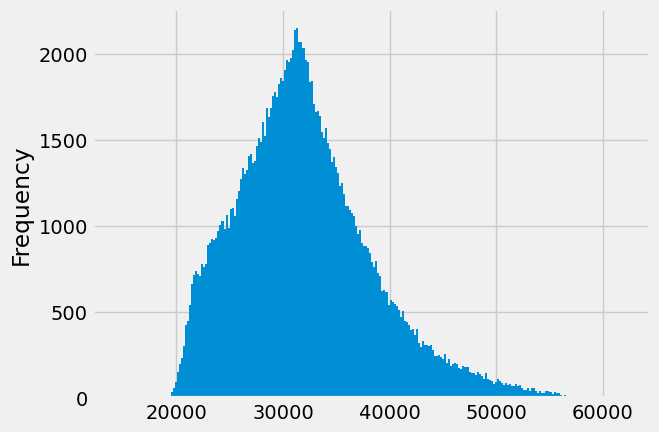

In [85]:
# Make a histogram of MegaWats

df["PJME_MW"].plot(kind="hist", bins =250)

In [86]:
df.describe() 

# 3 * STD = 19383

,PJME_MW
count,145362.000000
mean,32080.505139
std,6463.874131
min,14544.000000
25%,27573.000000
50%,31421.000000
75%,35650.000000
max,62009.000000


In [87]:
df = df.query("PJME_MW > 19383" ).copy()

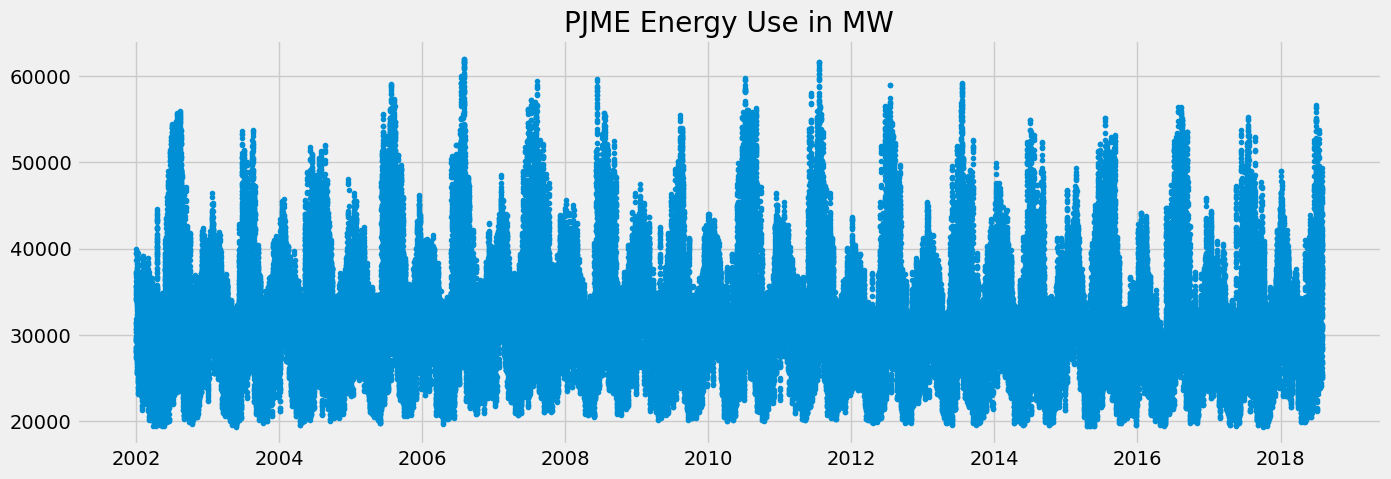

In [88]:
fig = plt.figure(figsize=(15, 5))
plt.plot(df, ".")
plt.title('PJME Energy Use in MW')
plt.show()

We can separate the time index into different parts, make a dummy variables when we can.

In [89]:
def make_features(df):  # We can add a feature of seasons and holidays

    #Create time series features based on time series index.

    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    
    return df

df = make_features(df)

In [90]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 145339 entries, 2002-12-31 01:00:00 to 2018-01-02 00:00:00
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   PJME_MW     145339 non-null  float64
 1   hour        145339 non-null  int64  
 2   dayofweek   145339 non-null  int64  
 3   quarter     145339 non-null  int64  
 4   month       145339 non-null  int64  
 5   year        145339 non-null  int64  
 6   dayofyear   145339 non-null  int64  
 7   dayofmonth  145339 non-null  int64  
 8   weekofyear  145339 non-null  UInt32 
dtypes: UInt32(1), float64(1), int64(7)
memory usage: 10.7 MB


Make a Time Index

In [91]:
df["timeIndex"] = np.arange(df.shape[0])

In [92]:
df.head(5)

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,timeIndex
Datetime,,,,,,,,,,
2002-12-31 01:00:00,26498.0,1,1,4,12,2002,365,31,1,0
2002-12-31 02:00:00,25147.0,2,1,4,12,2002,365,31,1,1
2002-12-31 03:00:00,24574.0,3,1,4,12,2002,365,31,1,2
2002-12-31 04:00:00,24393.0,4,1,4,12,2002,365,31,1,3
2002-12-31 05:00:00,24860.0,5,1,4,12,2002,365,31,1,4


Now, What does the data look like for different time ranges?

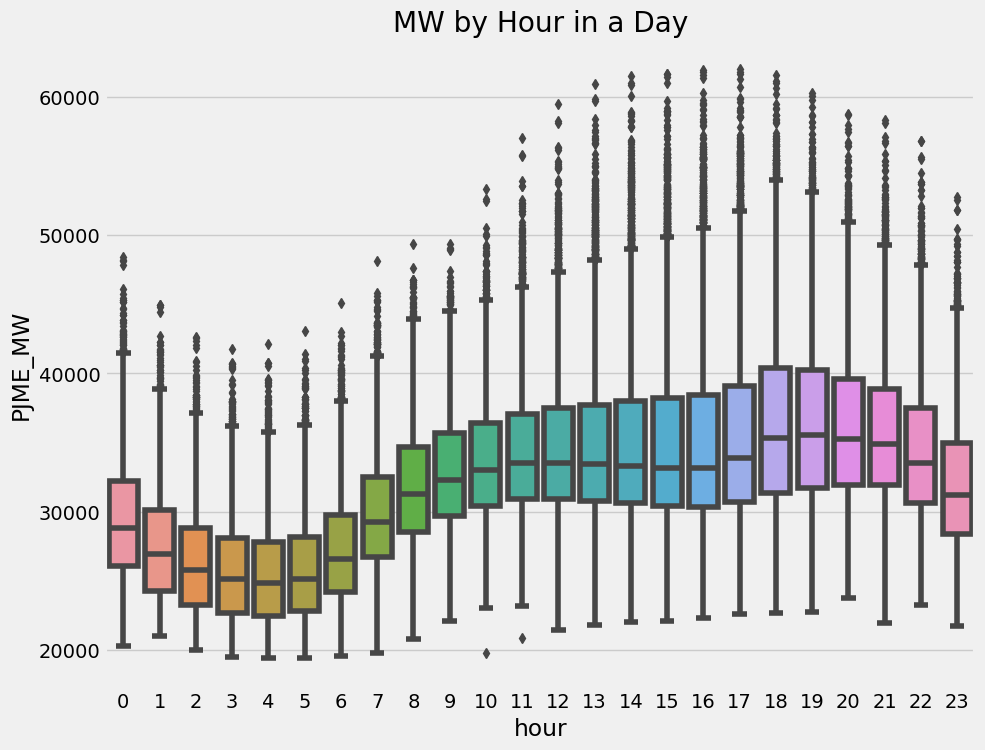

In [93]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='hour', y='PJME_MW')
ax.set_title('MW by Hour in a Day')
plt.show()

We have a depression at the night and a pic in the afternoon.

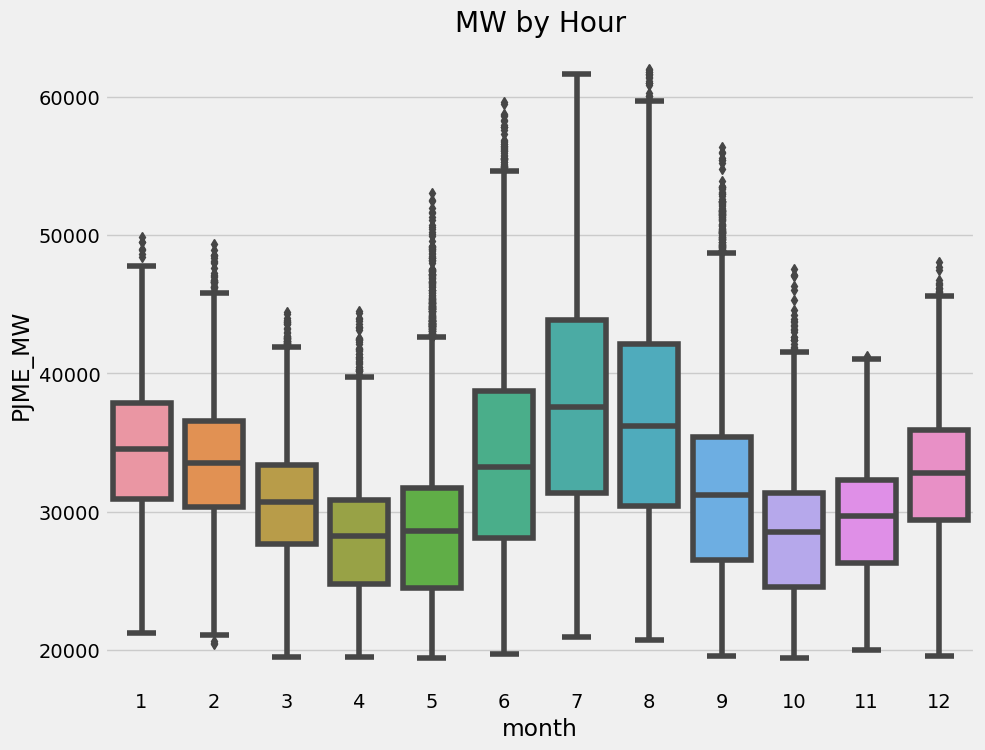

In [94]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='PJME_MW')
ax.set_title('MW by Hour')
plt.show()

How we can see, have a depression in winter and spring, and a peak in summer.

I am going to separate Train and Test before and after 2017.

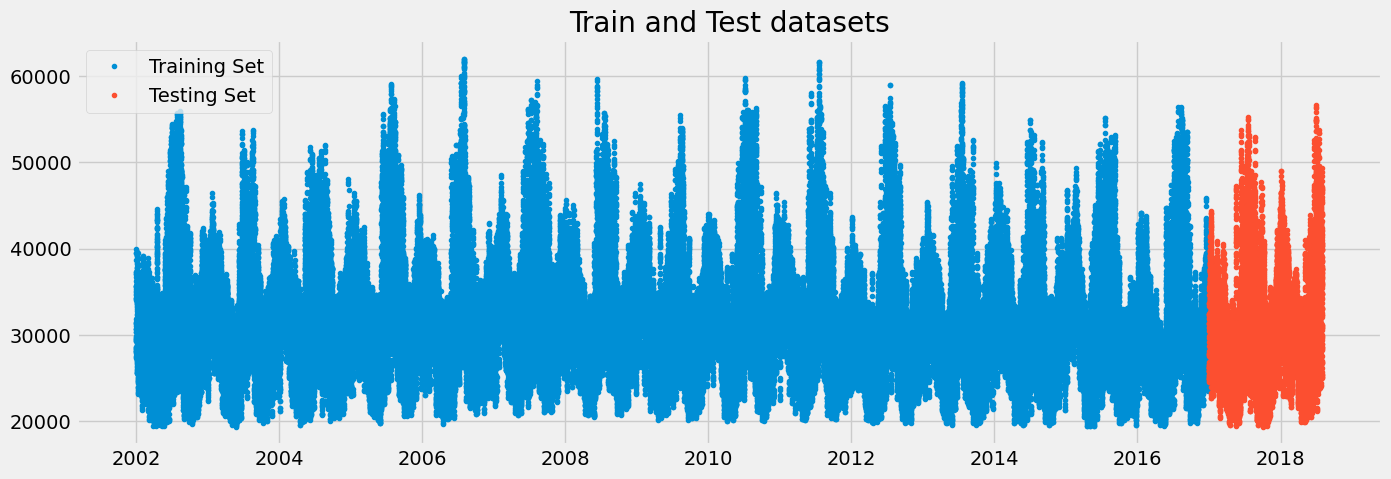

In [95]:
train = df.loc[df.index < '01-01-2017']
test = df.loc[df.index >= '01-01-2017']

fig = plt.figure(figsize=(15, 5))
plt.plot(train["PJME_MW"], ".", label="Training Set")
plt.plot(test["PJME_MW"], ".", label="Testing Set")
plt.title('Train and Test datasets')
plt.legend()
plt.show()

# First Model: constant Mean
---

It is our "null hypothesis", Constant Mean is the most naive and basic model. Basically we use the mean of train for the predictions.

In [96]:
model_mean_pred = train['PJME_MW'].mean()
model_mean_pred

32189.575250861562

In [97]:

train['Mean'] = model_mean_pred
test['Mean'] = model_mean_pred

C:\Users\User\AppData\Local\Temp\ipykernel_17576\2605450062.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Mean'] = model_mean_pred
C:\Users\User\AppData\Local\Temp\ipykernel_17576\2605450062.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Mean'] = model_mean_pred


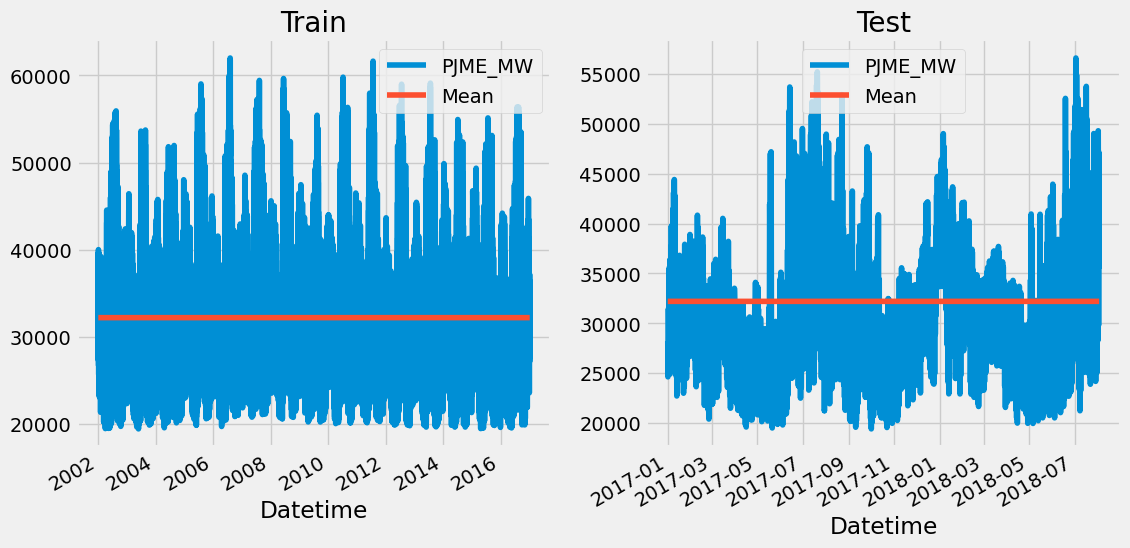

In [98]:
fig, axes = plt.subplots(1, 2,figsize=(12,6))
train.plot(ax=axes[0], y = ["PJME_MW","Mean"],title='Train')
test.plot(ax=axes[1], y = ["PJME_MW","Mean"], title='Test')
plt.show()

In [99]:
df_Results = pd.DataFrame(columns = ["Model", "RMSE", "MAE"])

df_Results.loc[0, "Model"] = "Mean"
df_Results.loc[0, "RMSE"] = mean_squared_error(test.Mean, test["PJME_MW"])
df_Results.loc[0, "MAE"] = mean_absolute_error(test.Mean, test["PJME_MW"])
df_Results.head()

,Model,RMSE,MAE
0,Mean,38728603.812,4982.475685


# Second Model: Monthly seasonality
---

We going to crate a Linear Model with the months how dummy variables. This model will have the months (and their seasonality) as a determining factor for energy consumption, a logical decision since consumption, as we have seen, varies greatly throughout the seasons of the year. 

We will apply this to the logarithm of consumption, so that we can lower the variance over time.

In [100]:
train['log_MW'] = np.log(train['PJME_MW'])
test['log_MW'] = np.log(test['PJME_MW'])

test

C:\Users\User\AppData\Local\Temp\ipykernel_17576\2390751943.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['log_MW'] = np.log(train['PJME_MW'])
C:\Users\User\AppData\Local\Temp\ipykernel_17576\2390751943.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['log_MW'] = np.log(test['PJME_MW'])


,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,timeIndex,Mean,log_MW
Datetime,,,,,,,,,,,,
2017-01-01 00:00:00,28171.0,0,6,1,1,2017,1,1,52,122688,32189.575251,10.246048
2017-12-31 01:00:00,35242.0,1,6,4,12,2017,365,31,52,131448,32189.575251,10.469994
2017-12-31 02:00:00,34410.0,2,6,4,12,2017,365,31,52,131449,32189.575251,10.446102
2017-12-31 03:00:00,34150.0,3,6,4,12,2017,365,31,52,131450,32189.575251,10.438518
2017-12-31 04:00:00,34220.0,4,6,4,12,2017,365,31,52,131451,32189.575251,10.440566
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-01-01 20:00:00,44284.0,20,0,1,1,2018,1,1,1,145334,32189.575251,10.698379
2018-01-01 21:00:00,43751.0,21,0,1,1,2018,1,1,1,145335,32189.575251,10.686270
2018-01-01 22:00:00,42402.0,22,0,1,1,2018,1,1,1,145336,32189.575251,10.654951


In [101]:
model_log_est = smf.ols("log_MW ~ timeIndex + C(month) + C(hour) + C(dayofweek)", data = train).fit()

model_log_est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 log_MW   R-squared:                       0.691
Model:                            OLS   Adj. R-squared:                  0.691
Method:                 Least Squares   F-statistic:                     7161.
Date:                Sun, 26 Mar 2023   Prob (F-statistic):               0.00
Time:                        09:46:36   Log-Likelihood:             1.0434e+05
No. Observations:              131447   AIC:                        -2.086e+05
Df Residuals:                  131405   BIC:                        -2.082e+05
Df Model:                          41                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            10.3959      0.002   5179.638      0.000      10.392      10.400
C(month)[T.2]        -0.0168      0.001    -11.187      0.000      -0.020      -0.014
C(month)[T.3]        -0.1195      0.001    -81.521      0.000      -0.122      -0.117
C(month)[T.4]        -0.2071      0.001   -140.217      0.000      -0.210      -0.204
C(month)[T.5]        -0.1846      0.001   -125.983      0.000      -0.187      -0.182
C(month)[T.6]        -0.0269      0.001    -18.223      0.000      -0.030      -0.024
C(month)[T.7]         0.0861      0.001     58.768      0.000       0.083       0.089
C(month)[T.8]         0.0536      0.001     36.588      0.000       0.051       0.056
C(month)[T.9]        -0.0977      0.001    -66.095      0.000      -0.101      -0.095
C(month)[T.10]       -0.2028      0.001   -138.275      0.000      -0.206      -0.200
C(month)[T.11]       -0.1591      0.001   -107.637      0.000      -0.162      -0.156
C(month)[T.12]       -0.0546      0.001    -37.205      0.000      -0.057      -0.052
C(hour)[T.1]         -0.0704      0.002    -33.650      0.000      -0.074      -0.066
C(hour)[T.2]         -0.1152      0.002    -55.046      0.000      -0.119      -0.111
C(hour)[T.3]         -0.1410      0.002    -67.394      0.000      -0.145      -0.137
C(hour)[T.4]         -0.1511      0.002    -72.273      0.000      -0.155      -0.147
C(hour)[T.5]         -0.1383      0.002    -66.115      0.000      -0.142      -0.134
C(hour)[T.6]         -0.0850      0.002    -40.660      0.000      -0.089      -0.081
C(hour)[T.7]          0.0005      0.002      0.224      0.823      -0.004       0.005
C(hour)[T.8]          0.0628      0.002     30.045      0.000       0.059       0.067
C(hour)[T.9]          0.1011      0.002     48.356      0.000       0.097       0.105
C(hour)[T.10]         0.1288      0.002     61.622      0.000       0.125       0.133
C(hour)[T.11]         0.1493      0.002     71.424      0.000       0.145       0.153
C(hour)[T.12]         0.1594      0.002     76.222      0.000       0.155       0.163
C(hour)[T.13]         0.1624      0.002     77.667      0.000       0.158       0.166
C(hour)[T.14]         0.1647      0.002     78.752      0.000       0.161       0.169
C(hour)[T.15]         0.1632      0.002     78.057      0.000       0.159       0.167
C(hour)[T.16]         0.1653      0.002     79.050      0.000       0.161       0.169
C(hour)[T.17]         0.1804      0.002     86.277      0.000       0.176       0.184
C(hour)[T.18]         0.2047      0.002     97.896      0.000       0.201       0.209
C(hour)[T.19]         0.2067      0.002     98.873      0.000       0.203       0.211
C(hour)[T.20]         0.2004      0.002     95.859      0.000       0.196       0.205
C(hour)[T.21]         0.1920      0.002     91.829      0.000       0.188

In [102]:
train['model_log_est'] = model_log_est.predict(train[["log_MW", "timeIndex", "month", "hour", "dayofweek"]])

test['model_log_est'] = model_log_est.predict(test[["log_MW", "timeIndex", "month", "hour", "dayofweek"]])

C:\Users\User\AppData\Local\Temp\ipykernel_17576\1437425951.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['model_log_est'] = model_log_est.predict(train[["log_MW", "timeIndex", "month", "hour", "dayofweek"]])
C:\Users\User\AppData\Local\Temp\ipykernel_17576\1437425951.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['model_log_est'] = model_log_est.predict(test[["log_MW", "timeIndex", "month", "hour", "dayofweek"]])


we recover the predicted value by applying exponential

In [103]:
train['back_LogEstTrend'] = np.exp(train['model_log_est'])
test['back_LogEstTrend'] = np.exp(test['model_log_est'])

C:\Users\User\AppData\Local\Temp\ipykernel_17576\2571295046.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['back_LogEstTrend'] = np.exp(train['model_log_est'])
C:\Users\User\AppData\Local\Temp\ipykernel_17576\2571295046.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['back_LogEstTrend'] = np.exp(test['model_log_est'])


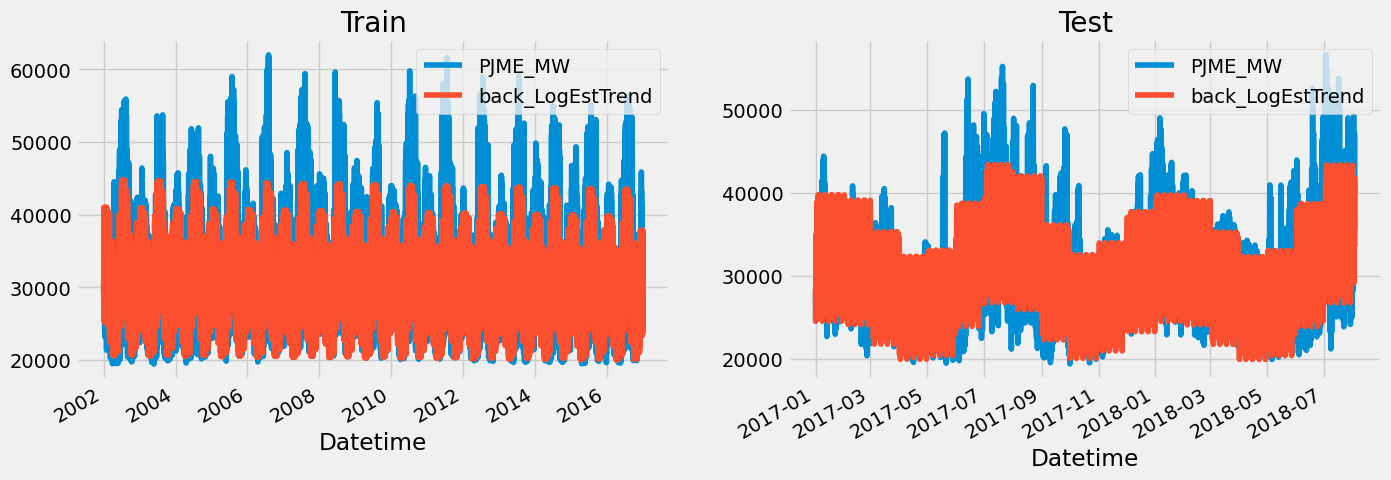

In [104]:
fig, axes = plt.subplots(1, 2,figsize=(15,5))
train.plot(kind = "line", y = ["PJME_MW","back_LogEstTrend"],ax=axes[0],title='Train')
test.plot(kind = "line", y = ["PJME_MW","back_LogEstTrend"],ax=axes[1],title='Test')
plt.show()

In [105]:

df_Results.loc[1, "Model"] = "back_LogEstTrend"
df_Results.loc[1, "RMSE"] = mean_squared_error(test["back_LogEstTrend"], test["PJME_MW"])
df_Results.loc[1, "MAE"] = mean_absolute_error(test["back_LogEstTrend"], test["PJME_MW"])
df_Results

,Model,RMSE,MAE
0,Mean,38728603.812,4982.475685
1,back_LogEstTrend,16270260.680711,3171.582666


# Cycle or stationary data
---

If our data is stationary we have a lot of settings for the analysis. The idea behind the definition of a stationary time series is that statistical measures remain constant or with minimal variation, regardless of time.

Using ADF algorithm we can know if an curve is stationary or no.
- if p > 0.05 (significance level greater than 5%), *$H_0$* is not rejected, and the series is not stationary.
- Otherwise, if p < 0.05, the null hypothesis is rejected and the series is considered stationary.

In [106]:
result = adfuller(train['PJME_MW'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in  result[4].items():
    print('Valor crítico %s: %.2f' % (key,value))

ADF Statistic: -19.141095
p-value: 0.000000
Valor crítico 1%: -3.43
Valor crítico 5%: -2.86
Valor crítico 10%: -2.57


Apply ADF to the Residuals

C:\Users\User\AppData\Local\Temp\ipykernel_17576\2421894636.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["residuals"] = res_Back_model


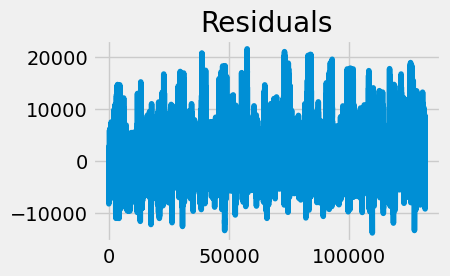

In [107]:
res_Back_model = train['PJME_MW'] - train['back_LogEstTrend']
train["residuals"] = res_Back_model
plt.figure(figsize=(4,2.5)); plt.plot(train.timeIndex, res_Back_model, '-')
plt.title("Residuals")
plt.show()

We see that we have very large residuals, close to the mean itself.

In [108]:
result = adfuller(res_Back_model)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in  result[4].items():
    print('Valor crítico %s: %.2f' % (key,value))

ADF Statistic: -28.710296
p-value: 0.000000
Valor crítico 1%: -3.43
Valor crítico 5%: -2.86
Valor crítico 10%: -2.57


How p-value is under to .05, our data is stationary.

### ARIMA MODEL

Con ARIMA analizamos los resudios para intentar encontrar alguna estacionaldiad inerente a los datos y no a los ciclos naturales predecibles de los mismos. Para eso entreno el modelo ARIMA con los residuos, capta esa estacionalidad inherente y la aplica para la preduccion.

- AR(p) = The term autoregression indicates that it is a regression of the variable against itself. We forecast the variable using a linear combination of past values of the series. An AR(p) model, is an autoregressive model of order p.
- MA(q) = A moving average model uses present and past unobservable shocks (white noise) based on a regression-like model. An MA(q) model, is a moving average model of order q.

The ARIMA model without seasonality arises from the combination of:
* An Auto-Regressive AR(p) model.
* A moving average model MA(q).
* A Differentiation process with an order of *Integration*. 

Its name is an acronym for: AutoRegressive Integrated Moving Average model.

The full model is written ARIMA(p,d,q) where:

* Number of AR (autoregressive) terms (p): is the order p of the AR(p) part of the model.

* Number of MA (moving average) terms (q): is the order q of the MA(q) part of the model.

* Number of differentiations (d): is the order of integration of the differentiation process. If the series is stationary, it is equal to zero, since it is not needed.

To determine the value of $p$ and $q$, we use Autocorrelation Function Plot (ACF) and Partial Autocorrelation Function Plot (PACF).

The rule to apply is:

- The series follows an *ARIMA(p,d,0)* pattern if:
    - ACF falls exponentially or sinusoidally.
    - PACF has a major peak at lag p, and no peaks beyond lag p, i.e. they fall in the blue region.
    
- The series follows an *ARIMA(0,d,q)* pattern if the opposite is true:
    - PACF falls exponentially or sinusoidally.
    - ACF has a major peak at lag q, and no peaks beyond lag q.
    
It is sometimes complemented by another rule, where zero is replaced by the first lags significantly greater than zero.

c:\Users\User\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


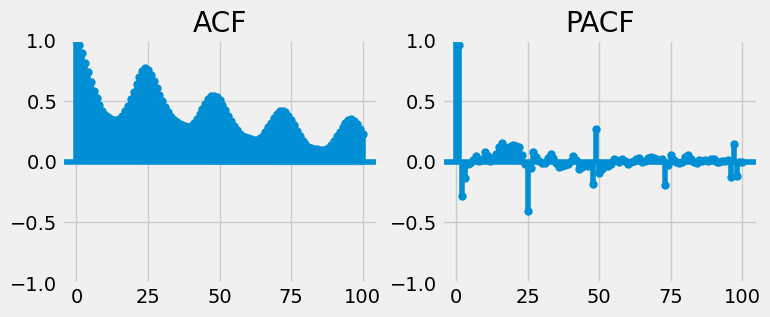

In [109]:
fig, axes = plt.subplots(1, 2,figsize=(8,3))
smt.graphics.plot_acf(res_Back_model, lags=100, ax=axes[0], title='ACF')
smt.graphics.plot_pacf(res_Back_model, lags=100, ax=axes[1], title='PACF')
plt.show()

We see a clear seasonality every 24 days.

Now we make the ARIMA model

We instantiate the model with the parameters determined in the ACF and PACF analysis.

- p=2, d=0, q=0. 

d=0 because the series is stationary.

In [110]:
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

model_ARIMA = sm.tsa.arima.ARIMA(train["residuals"], order=(2,0,2)) # Entreno el modelo de ARIMA con los residuos

#model_ARIMA = ARIMA(train["PJME_MW"], order=(2,0,2))

results_ARIMA = model_ARIMA.fit()

c:\Users\User\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\User\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\User\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\User\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\User\anaconda3\lib\site-packa

We analysed the results. Among others, AIC and BIC indicate, the lower the value, the better the model.

- AIC - Akaike Information Criterion.
- BIC - Bayesian Information Criterion (Schwartz).

In [111]:
print(results_ARIMA.summary())

                               SARIMAX Results                                
Dep. Variable:              residuals   No. Observations:               131447
Model:                 ARIMA(2, 0, 2)   Log Likelihood            -1099129.330
Date:                Sun, 26 Mar 2023   AIC                        2198270.659
Time:                        09:48:04   BIC                        2198329.377
Sample:                             0   HQIC                       2198288.262
                             - 131447                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        205.5991     46.500      4.421      0.000     114.460     296.738
ar.L1          1.4868      0.013    113.498      0.000       1.461       1.512
ar.L2         -0.5347      0.012    -44.239      0.0

We analyse the residuals of the ARIMA model obtained with the `resid()` method.

They appear to be correct, with the mean close to zero and a uniform variance.

Looking at the ACF and PACF plots, all peaks fall in the blue region. Showing that there is no autocorrelation.

The residual is now white noise.

c:\Users\User\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


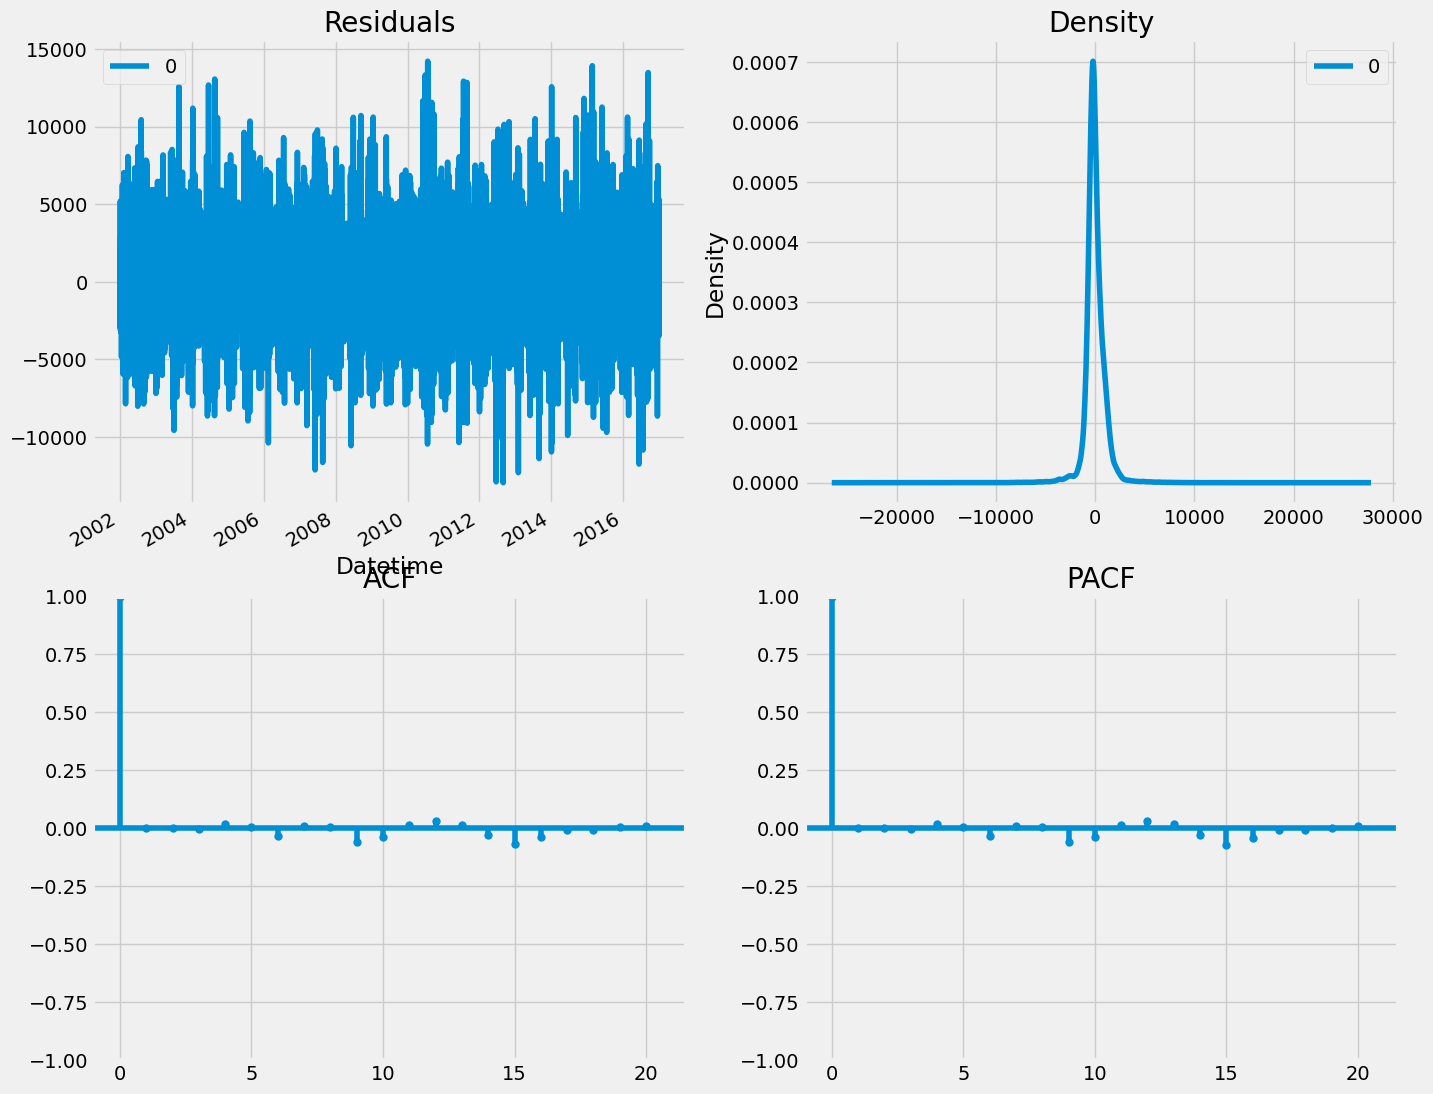

In [112]:
residuals = pd.DataFrame(results_ARIMA.resid)
fig, axes = plt.subplots(2, 2,figsize=(15,15))

residuals.plot(title="Residuals", ax=axes[0,0]); 
residuals.plot(kind='kde', title='Density', ax=axes[0,1])
smt.graphics.plot_acf(residuals, lags=20,ax=axes[1,0],title='ACF')
smt.graphics.plot_pacf(residuals, lags=20,ax=axes[1,1],title='PACF')
plt.show()

WE can see that ARIMA find (In ACF and PACF plots) a internal structure that cause seasonality in the data.

Make the Predictions with ARIMA

In [113]:
predictions_ARIMA = results_ARIMA.forecast(len(test["PJME_MW"])) # Realizo la prediccion
predictions_ARIMA.index = pd.to_datetime(test.index)
display (predictions_ARIMA)

c:\Users\User\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Datetime
2017-01-01 00:00:00      39.364312
2017-12-31 01:00:00     815.103876
2017-12-31 02:00:00    1200.703679
2017-12-31 03:00:00    1359.234004
2017-12-31 04:00:00    1388.760464
                          ...     
2018-01-01 20:00:00     205.599095
2018-01-01 21:00:00     205.599095
2018-01-01 22:00:00     205.599095
2018-01-01 23:00:00     205.599095
2018-01-02 00:00:00     205.599095
Name: predicted_mean, Length: 13892, dtype: float64

We add the results of the ARIMA model to the original values.

Recall that we ran the model on the residuals of the last calculated series, previously calculated: the differences between the original value of the series and the values predicted by the model with back transformation.

In [114]:
train['model_ARIMA_plus_LogEstTrend'] = train['back_LogEstTrend'] + results_ARIMA.fittedvalues 


test['model_ARIMA_plus_LogEstTrend'] = test['back_LogEstTrend'] + predictions_ARIMA 

C:\Users\User\AppData\Local\Temp\ipykernel_17576\2666756747.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['model_ARIMA_plus_LogEstTrend'] = train['back_LogEstTrend'] + results_ARIMA.fittedvalues
C:\Users\User\AppData\Local\Temp\ipykernel_17576\2666756747.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['model_ARIMA_plus_LogEstTrend'] = test['back_LogEstTrend'] + predictions_ARIMA


<AxesSubplot:title={'center':'Predictions in Train'}, xlabel='Datetime'>

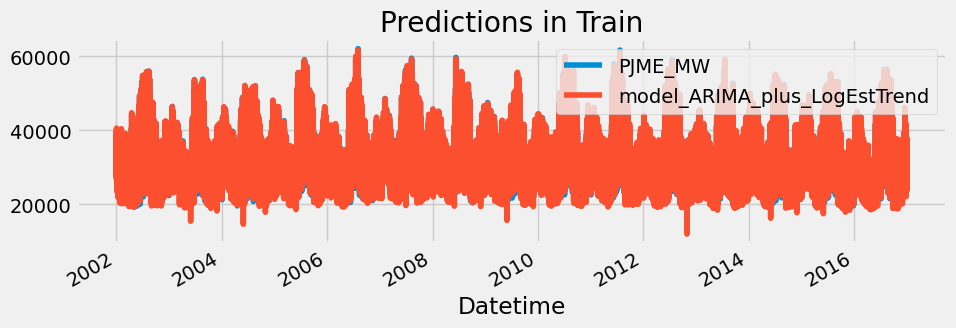

In [115]:
train.plot(kind = "line", y = ["PJME_MW", 'model_ARIMA_plus_LogEstTrend'],figsize=(10,3), title="Predictions in Train")

<AxesSubplot:title={'center':'Predictions in Test'}, xlabel='Datetime'>

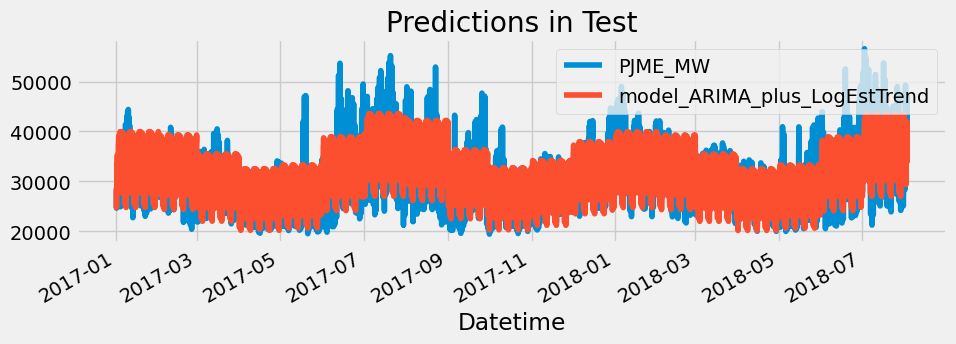

In [116]:
test.plot(kind = "line", y = ["PJME_MW", 'model_ARIMA_plus_LogEstTrend'], figsize=(10,3), title="Predictions in Test")

In [42]:
df_Results.loc[2, "Model"] = "Log Model + est + ARIMA"
df_Results.loc[2, "RMSE"] = mean_squared_error(test['model_ARIMA_plus_LogEstTrend'], test["PJME_MW"])
df_Results.loc[2, "MAE"] = mean_absolute_error(test['model_ARIMA_plus_LogEstTrend'], test["PJME_MW"])
df_Results

,Model,RMSE,MAE
0,Mean,38728603.812,4982.475685
1,back_LogEstTrend,16270260.680711,3171.582666
2,Log Model + est + ARIMA,16508782.014794,3223.819178


# Machine Learning Models

For this models, we going to separate our data in X_train, X_test, y_tran and y_test.

## Fourth model: XGBoost
---

### Train using Cross Validation

In [43]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()

In [44]:
# Make a Cross Validation with 5 different folds and save the scores

fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = make_features(train)
    test = make_features(test)

    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
    TARGET = 'PJME_MW'


    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    XGB_model = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    
    XGB_model.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = XGB_model.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[00:30:44] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32734.30327	validation_1-rmse:31955.88874
[100]	validation_0-rmse:12614.53120	validation_1-rmse:11906.16800
[200]	validation_0-rmse:5818.83055	validation_1-rmse:5369.84563
[300]	validation_0-rmse:3884.71273	validation_1-rmse:3878.00532
[400]	validation_0-rmse:3417.14559	validation_1-rmse:3732.72455
[500]	validation_0-rmse:3261.34222	validation_1-rmse:3719.93801
[506]	validation_0-rmse:3255.31831	validation_1-rmse:3721.15986
[00:30:46] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32674.61563	validation_1-rmse:32130.68765
[100]	validation_0-rmse:

Now, we can use 5 different experiments and see how the score behaves with each one. The hyperparameters we are going to use are going to be the best over the 5 folds.
We see the average obtained by all the scores and each score obtained individually. 

In [45]:
print(np.mean(scores))
print(scores) # Here we can see the 5 different scores for each one.

3678.6332861753035
[3718.226431428566, 3459.1279228161716, 3555.8796882801425, 3765.1956502651865, 3894.7367380864516]


We can see that in n=500 we have the best score, because from this value we start to have overfitting.

In [46]:
df = make_features(df)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'PJME_MW'

X = df[FEATURES]
y = df[TARGET]


X_train= X.loc[df.index < '01-01-2017']
y_train= y.loc[df.index < '01-01-2017']


X_test= X.loc[df.index >= '01-01-2017']
y_test= y.loc[df.index >= '01-01-2017']

XGB_model = xgb.XGBRegressor(base_score=0.5, booster='gbtree', n_estimators=500, objective='reg:linear', max_depth=3, learning_rate=0.01)

XGB_model.fit(X_train, y_train, eval_set=[(X_train, y_train)], verbose=100)

[00:31:04] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32515.38353
[100]	validation_0-rmse:12565.10580
[200]	validation_0-rmse:5854.63437
[300]	validation_0-rmse:3958.48859
[400]	validation_0-rmse:3489.07214
[499]	validation_0-rmse:3336.00577


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

## Feature Importance

In [47]:
Feature_importance = pd.DataFrame(data = XGB_model.feature_importances_, index= XGB_model.feature_names_in_, columns=["Importance"])
Feature_importance

,Importance
dayofyear,0.166877
hour,0.308777
dayofweek,0.173453
quarter,0.048468
month,0.273078
year,0.029348


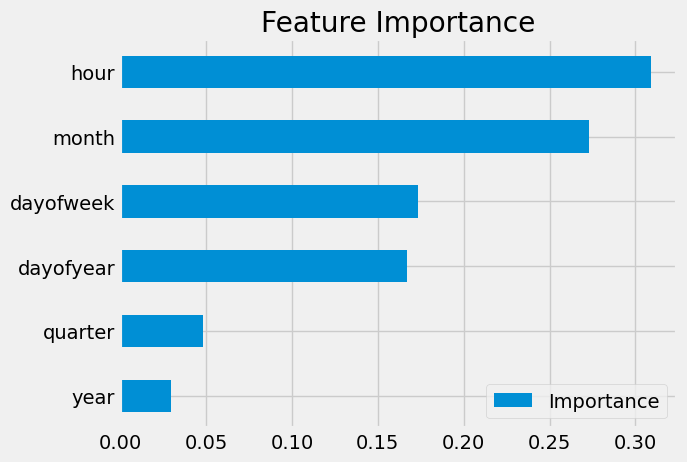

In [48]:
Feature_importance.sort_values('Importance').plot(kind='barh', title='Feature Importance')
plt.show()

## Forecast on Test

C:\Users\User\AppData\Local\Temp\ipykernel_17576\2652385565.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['prediction_XGB'] = XGB_model.predict(X_test)


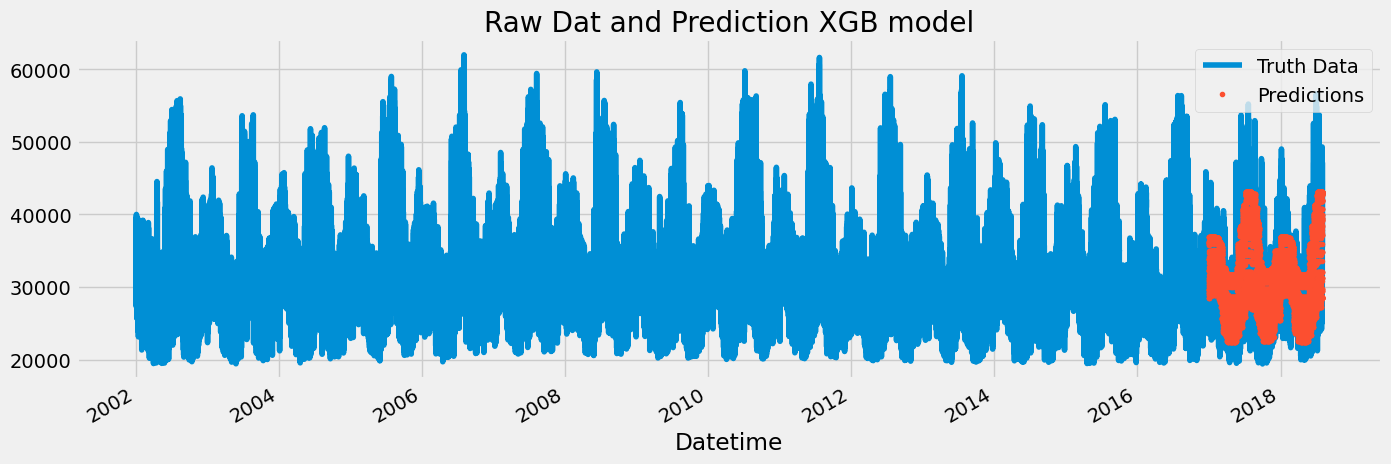

In [49]:
X_test['prediction_XGB'] = XGB_model.predict(X_test)
df = df.merge(X_test[['prediction_XGB']], how='left', left_index=True, right_index=True)
ax = df[['PJME_MW']].plot(figsize=(15, 5))
df['prediction_XGB'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction XGB model')
plt.show()

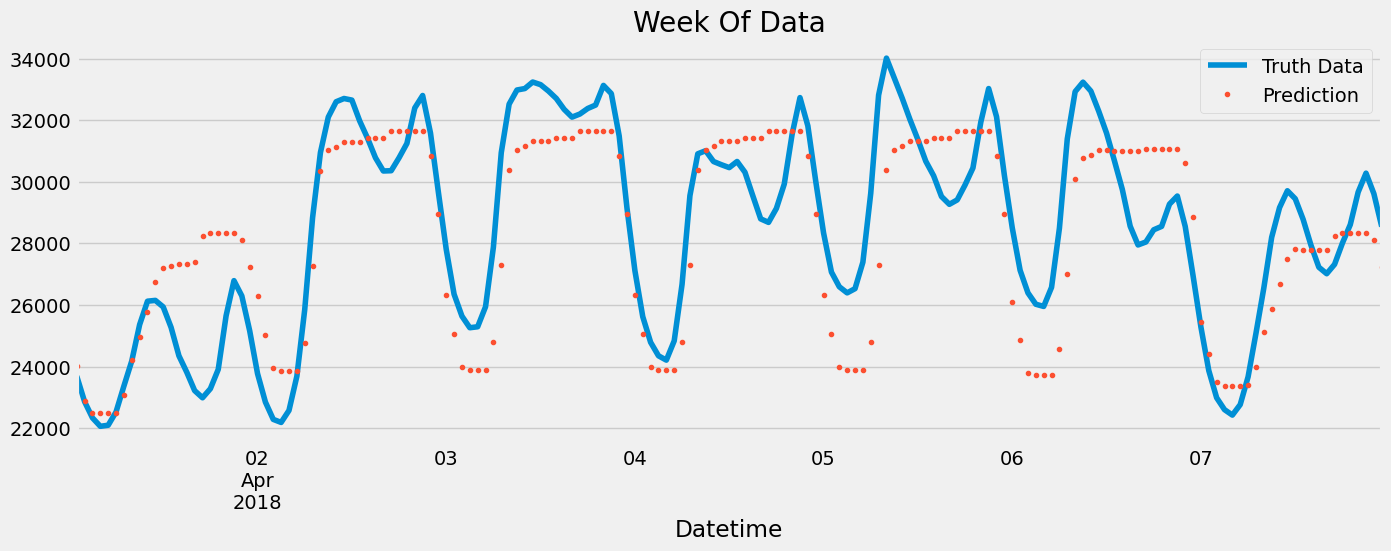

In [50]:
ax = df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['PJME_MW'].plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['prediction_XGB'].plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

In [51]:
X_test['error'] = np.abs(y_test - X_test['prediction_XGB'])
X_test['date'] = X_test.index.date
X_test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10) #Esta en orden de los peores dias predichos

C:\Users\User\AppData\Local\Temp\ipykernel_17576\333054409.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['error'] = np.abs(y_test - X_test['prediction_XGB'])
C:\Users\User\AppData\Local\Temp\ipykernel_17576\333054409.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['date'] = X_test.index.date


date
2018-01-06    11182.968913
2018-01-07    10266.597005
2017-12-31     9912.718669
2018-01-05     9788.410726
2018-07-03     9447.116211
2018-07-02     9424.646159
2017-05-19     9316.863932
2017-06-13     8761.168132
2017-12-28     8545.004150
2017-05-18     8212.723063
Name: error, dtype: float64

In [52]:
df_Results.loc[3, "Model"] = "XGBoost"
df_Results.loc[3, "RMSE"] = mean_squared_error(X_test['prediction_XGB'], y_test)
df_Results.loc[3, "MAE"] = mean_absolute_error(X_test['prediction_XGB'], y_test)
df_Results

,Model,RMSE,MAE
0,Mean,38728603.812,4982.475685
1,back_LogEstTrend,16270260.680711,3171.582666
2,Log Model + est + ARIMA,16508782.014794,3223.819178
3,XGBoost,15295271.134349,3084.787659


We see that we have a tendency to have a large number of estimators, so let's try high values of n_estimators in the grid.

In [53]:
from sklearn.model_selection import cross_val_score, StratifiedKFold 
from sklearn.model_selection import GridSearchCV


cv = StratifiedKFold(n_splits=5, random_state=41, shuffle=True) 


H_params_XGB = { # Make a dicctionary of hyperparameters
    'min_child_weight': [i for i in range(0,4)],
    'subsample':  [i/10.0 for i in range(8,13)],
    'colsample_bytree': [i/10.0 for i in range(3,8)],
    'max_depth':[i for i in range(3,9)],
    "n_estimators": [600, 900, 1000, 1100, 1200]
    }  


grid = GridSearchCV(XGB_model, H_params_XGB, n_jobs=-1, cv=cv)  # Here we make the GridSearchCV 

    #-------------- Grid Train ----------------------

result_grid = grid.fit(X_train, y_train) # Train the model with the best hyperparameters
    # summarize result

print('Best Score: %s' % result_grid.best_score_)
print('Best Hyperparameters: %s' % result_grid.best_params_)
    
y_pred_grid = grid.predict(X_test.drop(["prediction_XGB", "error","date"], axis=1))

c:\Users\User\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\User\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
6000 fits failed out of a total of 15000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3000 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\User\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\User\anaconda3\lib\site-packages\xgboost\core.py", line 620, in inner_f
    return func(**kwarg

[05:28:13] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
Best Score: 0.9088417243041638
Best Hyperparameters: {'colsample_bytree': 0.7, 'max_depth': 8, 'min_child_weight': 2, 'n_estimators': 1200, 'subsample': 0.8}


C:\Users\User\AppData\Local\Temp\ipykernel_17576\316837281.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['prediction_XGB_plus_grid'] = y_pred_grid


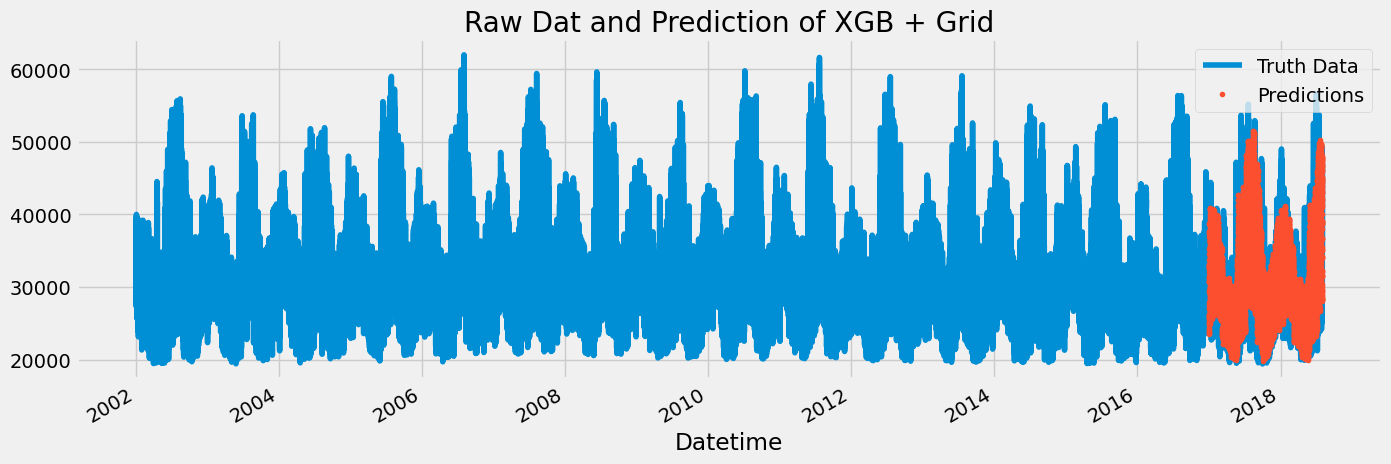

In [54]:
X_test['prediction_XGB_plus_grid'] = y_pred_grid
df = df.merge(X_test[['prediction_XGB_plus_grid']], how='left', left_index=True, right_index=True)
ax = df[['PJME_MW']].plot(figsize=(15, 5))
df['prediction_XGB_plus_grid'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction of XGB + Grid')
plt.show()

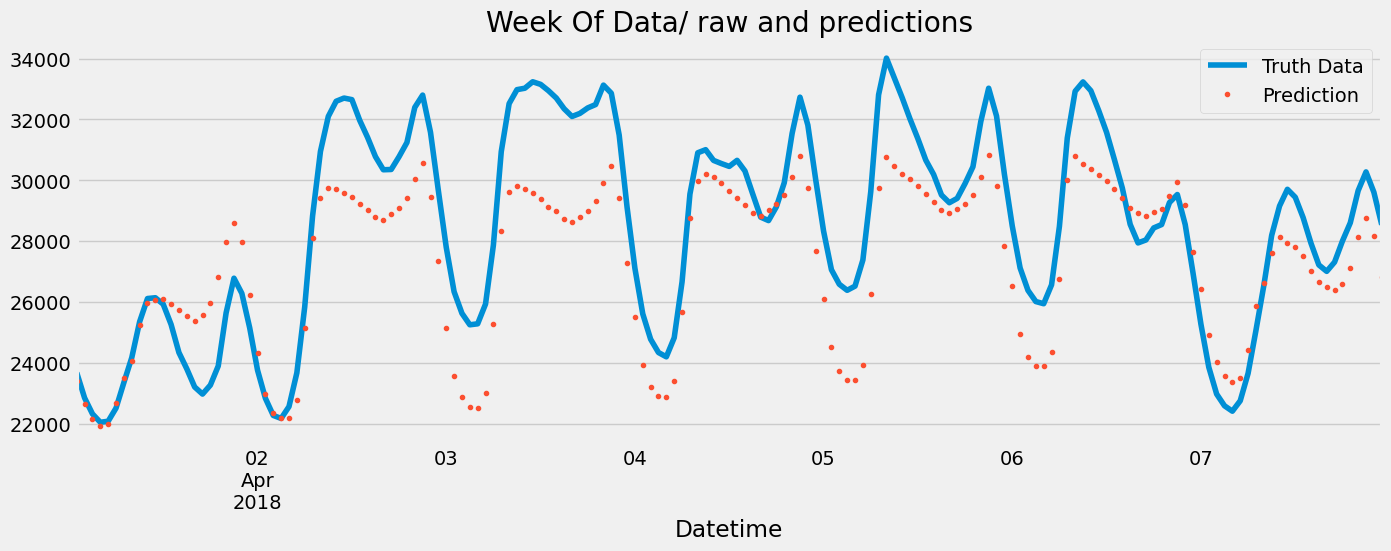

In [55]:
ax = df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['PJME_MW'].plot(figsize=(15, 5), title='Week Of Data/ raw and predictions')
df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['prediction_XGB_plus_grid'].plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

In [56]:
df_Results.loc[4, "Model"] = "XGBoost + Grid"
df_Results.loc[4, "RMSE"] = mean_squared_error(y_pred_grid, y_test)
df_Results.loc[4, "MAE"] = mean_absolute_error(y_pred_grid, y_test)
df_Results

,Model,RMSE,MAE
0,Mean,38728603.812,4982.475685
1,back_LogEstTrend,16270260.680711,3171.582666
2,Log Model + est + ARIMA,16508782.014794,3223.819178
3,XGBoost,15295271.134349,3084.787659
4,XGBoost + Grid,18637856.266481,3160.934536


# Pipeline Implementation

---

In [57]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin


In [58]:
#Feature cration DONE

class Feature_Creation(BaseEstimator, TransformerMixin):
    def __init__(self, target):
        self.target =target

    def fit(self,X, y=None):
        return self
    
    def transform(self, X, y=None):
        X = X.set_index('Datetime')
        X.index = pd.to_datetime(X.index)
        X['hour'] = X.index.hour
        X['dayofweek'] = X.index.dayofweek
        X['quarter'] = X.index.quarter
        X['month'] = X.index.month
        X['year'] = X.index.year
        X['dayofyear'] = X.index.dayofyear
        X['dayofmonth'] = X.index.day
        X['weekofyear'] = X.index.isocalendar().week
        X["timeIndex"] = np.arange(X.shape[0])
        X['log_MW'] = np.log(X[self.target])
        return X, y
        

In [59]:
# MODEL OLS  DONE

class Model_OLS(BaseEstimator, TransformerMixin):
    def __init__(self, formula):
        self.formula=formula

    def fit(self,X, y=None):
  
        self.model = smf.ols(self.formula, data=X).fit()
        return self
    
    def predict(self, X, y=None):
        return self.model.predict(X)

In [60]:
#Delete Duplicates DONE

class Delete_Duplicate(BaseEstimator, TransformerMixin):
    def __init__(self):
        self

    def fit(self,X, y=None):
        return self
    
    def transform(self, X, y=None):
        mask = ~X.index.duplicated()
        X = X[mask]
        
        return X, y

In [61]:
#Delete Outliers DONE


class Delete_Outliers(BaseEstimator, TransformerMixin):
    def __init__(self, power):
        self.power = power

    def fit(self,X, y=None):
        return self
    
    def transform(self, X, y=None):
        mask = abs(X[self.power] - X[self.power].mean()) < 3 * X[self.power].std()
        X = X[mask]

        return X, y

In [62]:
class Separate_Xy(BaseEstimator, TransformerMixin):
    def __init__(self, index):
        self.index = index

    def fit(self,X, y):
        return self
    
    def transform(self, X, y):
        y= X.DOM_MW
        X= X.drop("DOM_MW", axis=1)
        

        return X, y

Lets work the pipeline eith DOM_hourly

In [63]:
data2 = pd.read_csv("DOM_hourly.csv") # Vemos que estos datos terminan a inicios de 2018. Intentemos predecir  todo 2017 para adelante
X_2= data2.Datetime
y_2= data2.DOM_MW
data2.loc[data2.Datetime < "2017-01-01 02:00:00"] # el index para el 2017 en adelante es 111030

,Datetime,DOM_MW
0,2005-12-31 01:00:00,9389.0
1,2005-12-31 02:00:00,9070.0
2,2005-12-31 03:00:00,9001.0
3,2005-12-31 04:00:00,9042.0
4,2005-12-31 05:00:00,9132.0
...,...,...
102290,2016-01-01 21:00:00,11227.0
102291,2016-01-01 22:00:00,11025.0
102292,2016-01-01 23:00:00,10705.0
102293,2016-01-02 00:00:00,10369.0


In [64]:
X = pd.read_csv("DOM_hourly.csv")

X = X.set_index('Datetime')
X.index = pd.to_datetime(X.index)
X['hour'] = X.index.hour
X['dayofweek'] = X.index.dayofweek
X['quarter'] = X.index.quarter
X['month'] = X.index.month
X['year'] = X.index.year
X['dayofyear'] = X.index.dayofyear
X['dayofmonth'] = X.index.day
X['weekofyear'] = X.index.isocalendar().week
X["timeIndex"] = np.arange(X.shape[0])
X['log_MW'] = np.log(X["DOM_MW"])
X

,DOM_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,timeIndex,log_MW
Datetime,,,,,,,,,,,
2005-12-31 01:00:00,9389.0,1,5,4,12,2005,365,31,52,0,9.147294
2005-12-31 02:00:00,9070.0,2,5,4,12,2005,365,31,52,1,9.112728
2005-12-31 03:00:00,9001.0,3,5,4,12,2005,365,31,52,2,9.105091
2005-12-31 04:00:00,9042.0,4,5,4,12,2005,365,31,52,3,9.109636
2005-12-31 05:00:00,9132.0,5,5,4,12,2005,365,31,52,4,9.119540
...,...,...,...,...,...,...,...,...,...,...,...
2018-01-01 20:00:00,18418.0,20,0,1,1,2018,1,1,1,116184,9.821084
2018-01-01 21:00:00,18567.0,21,0,1,1,2018,1,1,1,116185,9.829141
2018-01-01 22:00:00,18307.0,22,0,1,1,2018,1,1,1,116186,9.815039


In [65]:
data2 = pd.read_csv("DOM_hourly.csv")

X_2= data2.Datetime
y_2= data2.DOM_MW


X_train_2= X_2.loc[X_2.index < 111030]
y_train_2= y_2.loc[y_2.index < 111030]


X_test_2= X_2.loc[data2.index >= 111030]
y_test_2= y_2.loc[data2.index >= 111030]

In [66]:
data2 = pd.read_csv("DOM_hourly.csv")

X_train_2= data2.loc[data2.Datetime < "2017-01-01 02:00:00"]

X_test_2= data2.loc[data2.Datetime > "2017-01-01 02:00:00"]

make a list of steps

In [67]:
pasos= [('dupli',Delete_Duplicate()),
        ('outliers',Delete_Outliers(power="DOM_MW")),
        ('features',Feature_Creation(target="DOM_MW")),
        ("OLS",Model_OLS(formula="log_MW ~ timeIndex + C(month) + C(hour) + C(dayofweek)"))
        #("X_y",Separate_Xy()),
        #('regressor', xgb.XGBRegressor())
        ]

pipe=Pipeline(pasos)

In [68]:
pipe.fit(X_train_2)

TypeError: tuple indices must be integers or slices, not str

In [ ]:
X_ = pipe.steps[0][1].fit_transform(X_train_2)

In [ ]:
X_ = pipe.steps[1][1].fit_transform(X_)

TypeError: tuple indices must be integers or slices, not str

In [ ]:
X_ = pipe.steps[3][1].fit(X_)

- Definimos la grilla para el`GridSearch` y entrenamos el modelo en Train.

In [ ]:
H_params_XGB = { # Make a dicctionary of hyperparameters
    'min_child_weight': [i for i in range(0,3)],
    'gamma': [i/10.0 for i in range(0,3)],
    'subsample':  [i/10.0 for i in range(9,12)],
    'colsample_bytree': [i/10.0 for i in range(4,8)],
    'reg_alpha': [1e-5, 1e-2, 0.1, 1], 
    'max_depth':[i for i in range(2,6)],
    "n_estimators": [250,275,300,325, 350, 375]
    } 

In [ ]:
param_grid = [{'feature_engineering':[union],
            'regressor__n_estimator':[160, 175, 185, 200], 
            #'regressor__eta':[0.1,0.3, 0.4],
            #"regressor__gamma":[i/10.0 for i in range(0,3)],
            #"regressor__subsamble":[i/10.0 for i in range(8,12)],
            #"regressor__reg_alpha":[0, 1e-5, 1e-2, 0.1, 1, 3],
            "regressor__max_depth":[i for i in range(3,6)],
            #"regressor__colsample_bytree":[i/10.0 for i in range(7,10)],
            "regressor__min_child_weight":[i for i in range(0,3)] }]

folds=StratifiedKFold(n_splits=5,shuffle=True, random_state=42)

grid_final=GridSearchCV(pipe_grid, param_grid, cv=folds)

grid_final.fit(X_train_2,y_train_2)

c:\Users\User\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\User\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
180 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
180 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\User\anaconda3\lib\site-packages\pandas\core\indexes\base.py", line 3629, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 136, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 144, in pandas._

KeyError: 'DOM_MW'

### grid y xgb
---

In [ ]:
out = Delete_Outliers("DOM_MW")

out.transform(data2)

In [ ]:
ols=Model_OLS("log_MW ~ timeIndex + C(month) + C(hour) + C(dayofweek)")

In [ ]:
ols.fit(train)
ols.predict(train)

In [ ]:
data2 = pd.read_csv("DOM_hourly.csv")
#data2 = data2.set_index('Datetime')
#data2.index = pd.to_datetime(data2.index)
data2


,Datetime,DOM_MW
0,2005-12-31 01:00:00,9389.0
1,2005-12-31 02:00:00,9070.0
2,2005-12-31 03:00:00,9001.0
3,2005-12-31 04:00:00,9042.0
4,2005-12-31 05:00:00,9132.0
...,...,...
116184,2018-01-01 20:00:00,18418.0
116185,2018-01-01 21:00:00,18567.0
116186,2018-01-01 22:00:00,18307.0
116187,2018-01-01 23:00:00,17814.0


In [ ]:
df2 = Feature_Creation()

In [ ]:
#Delete Outliers DONE


class XGB_model(BaseEstimator, TransformerMixin):
    def __init__(self, formula):
        self.formula=formula

    def fit(self,X,y=None):
        self.model = smf.ols(self.formula, data=X).fit()
        return self
    
    def predict(self, X, y=None):
        return self.model.predict(X)

### pipeline of xgb with grid

In [ ]:
H_params_XGB = { # Make a dicctionary of hyperparameters
    'min_child_weight': [i for i in range(0,3)],
    'gamma': [i/10.0 for i in range(0,3)],
    'subsample':  [i/10.0 for i in range(9,12)],
    'colsample_bytree': [i/10.0 for i in range(4,8)],
    'reg_alpha': [1e-5, 1e-2, 0.1, 1], 
    'max_depth':[i for i in range(2,6)],
    "n_estimators": [250,275,300,325, 350, 375]
    }  